In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the metadata (first 14 rows) and telemetry (rest) separately
file_path = 'Jaden Pariat Round 3 Race 1 Telemetry.csv'

# Load the metadata (first 14 rows)
metadata_df = pd.read_csv(file_path, nrows=14, header=None, engine='python')

# Load the telemetry data (from row 15 onwards)
telemetry_df = pd.read_csv(file_path, skiprows=14, low_memory=False)
# Load the CSV file
telemetry_df = pd.read_csv(file_path, skiprows=14, low_memory=False)

# Convert all columns to numeric where possible, coercing errors to NaN
for col in telemetry_df.columns:
    telemetry_df[col] = pd.to_numeric(telemetry_df[col], errors='coerce')

# Proceed with the rest of your code
del_df = [2, 3]  # Adjust the columns to be deleted as needed
telemetry_df = telemetry_df.drop(index=metadata_df.index[del_df])


In [19]:
# Extract vehicle number and driver's name from the metadata dataframe
championship = metadata_df.iloc[2, 1]
vehicle_number = metadata_df.iloc[2, 1]  # Vehicle number is in row 3 (index 2) and column 2 (index 1)
driver_name = metadata_df.iloc[3, 1]  # Driver's name is in row 4 (index 3) and column 2 (index 1)

# Step 2: Extract segment times from metadata
segment_times_raw = metadata_df.iloc[12].values[1:]  # Skip the first column as it may contain labels

# Convert segment times to seconds
segment_times = []
for time in segment_times_raw:
    if isinstance(time, str):
        minutes, seconds = map(float, time.split(':'))
        total_seconds = minutes * 60 + seconds
        segment_times.append(total_seconds)


C:\Users\HP\AppData\Local\Temp\ipykernel_14424\3608378266.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telemetry_FL['Distance'] = telemetry_FL['Distance on GPS Speed'] - start_distance
C:\Users\HP\AppData\Local\Temp\ipykernel_14424\3608378266.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telemetry_FL['Action'] = 'Turning'  # Default action is Turning
C:\Users\HP\AppData\Local\Temp\ipykernel_14424\3608378266.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

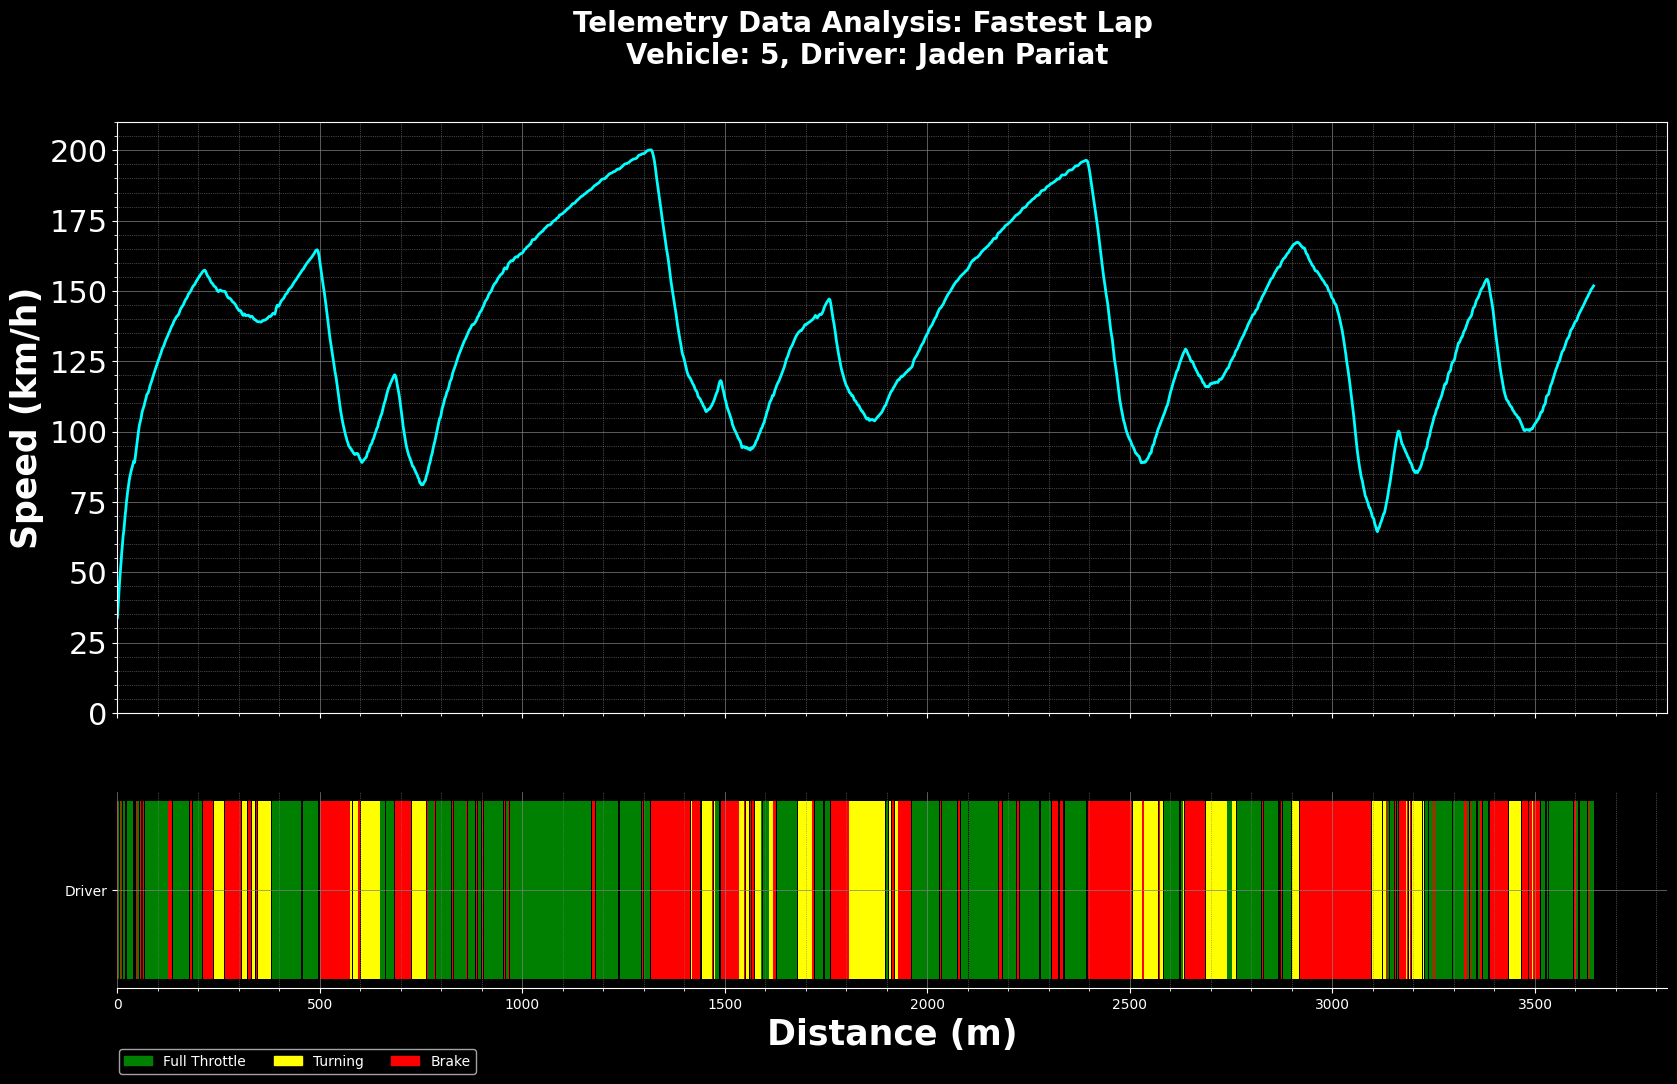

In [20]:
# Step 3: Remove outliers for lap times (acceptable range: 95 seconds to 120 seconds)
laps_array = [time for time in segment_times if 95 <= time <= 120]

# Step 4: Calculate start and end timestamps for the fastest lap
fastest_lap_time = min(laps_array)

# Find the index of the fastest lap
fastest_lap_index = laps_array.index(fastest_lap_time)

# Calculate the start and end timestamps for the fastest lap
start_time_stamp = sum(segment_times[:fastest_lap_index])
end_time_stamp = sum(segment_times[:fastest_lap_index + 1])

# Step 5: Filter telemetry data for the fastest lap
telemetry_FL = telemetry_df[(telemetry_df['Time'] >= start_time_stamp) & (telemetry_df['Time'] <= end_time_stamp)]

# Step 6: Adjust the distance calculation to be relative to the start of the fastest lap
start_distance = telemetry_FL['Distance on GPS Speed'].iloc[0]
end_distance = telemetry_FL['Distance on GPS Speed'].iloc[-1]

# Recalculate the distance relative to the start of the fastest lap
telemetry_FL['Distance'] = telemetry_FL['Distance on GPS Speed'] - start_distance

# Step 7: Classify telemetry actions based on throttle and brake positions
throttle_threshold = 90
brake_pos_median = telemetry_FL['Brake Pos'].median()
brake_press_median = telemetry_FL['Brake Press'].median()

# Classify actions
telemetry_FL['Action'] = 'Turning'  # Default action is Turning
telemetry_FL.loc[telemetry_FL['Throttle Pos'] > throttle_threshold, 'Action'] = 'Full Throttle'
telemetry_FL.loc[(telemetry_FL['Brake Pos'] > brake_pos_median) & 
                 (telemetry_FL['Brake Press'] > brake_press_median), 'Action'] = 'Brake'

# Step 8: Plot the telemetry data (Speed and Actions)

# Use the recalculated distance and speed for the x and y axes
telemetry_FL['Speed_kmph'] = telemetry_FL['GPS Speed']  # Speed is already in km/h

# Plotting with shared x-axis
plt.style.use('dark_background')

# Create subplots for speed and telemetry actions, sharing the x-axis
fig, ax = plt.subplots(2, figsize=(20, 11.25), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Plot Speed vs Distance (Top Plot)
ax[0].plot(telemetry_FL['Distance'], telemetry_FL['Speed_kmph'], label='Speed', color='cyan', linewidth=2)
ax[0].set_ylabel('Speed (km/h)', fontweight='bold', fontsize=25)
ax[0].set_ylim(0, 210)  # Adjust y-axis to speed range of 0 to 210 km/h
ax[0].tick_params(axis='y', which='major', labelsize=22)
ax[0].tick_params(axis='x', which='major', labelsize=15)

# Add grid lines with less prominent appearance
ax[0].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
ax[0].minorticks_on()

# Plot Telemetry Actions (Bottom Plot)
actions = ['Full Throttle', 'Turning', 'Brake']
action_colors = {'Full Throttle': 'green', 'Turning': 'yellow', 'Brake': 'red'}

for driver in ['Driver']:  # Placeholder driver name
    driver_data = telemetry_FL.copy()
    previous_action_end = 0

    action_changes = driver_data['Action'].ne(driver_data['Action'].shift()).cumsum()
    driver_data['ActionID'] = action_changes

    grouped_actions = driver_data.groupby('ActionID')
    for _, group in grouped_actions:
        action_type = group['Action'].iloc[0]
        color = action_colors[action_type]
        ax[1].barh(driver, group['Distance'].max() - group['Distance'].min(),
                   left=group['Distance'].min(), color=color)

# Set x-label for both plots
ax[1].set_xlabel('Distance (m)', fontweight='bold', fontsize=25)
ax[1].invert_yaxis()

# Add grid lines with less prominent appearance
ax[1].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
ax[1].minorticks_on()

# Remove frame from the second plot
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Adjust the legend to be further down and in a horizontal format
labels = list(action_colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=action_colors[label]) for label in labels]
ax[1].legend(handles, labels, fontsize=10, ncol=3, bbox_to_anchor=(0.0, -0.3), loc='upper left', borderaxespad=0.1)

# Set overall title
plot_title = f"Telemetry Data Analysis: Fastest Lap \nVehicle: {vehicle_number}, Driver: {driver_name}"
plt.suptitle(plot_title, fontsize=20, fontweight='bold')

# Show the plot
st.pyplot(fig)
